## K8 Setup with Kubeadm - Part 2
____

+ Setup K8s Clusters with Kubeadm
+ Setup on GCP( to be done)
+ Setup on play K8s (to be done)


## Setup  K8s Clusters with Kubeadm
___

Back to docs..


1. https://kubernetes.io/
2. Click Documentation, Getting Started, Production environment, Installing K8s with deployent tools, Bootstrapping clusters with Kubeadm
3. Click on Installing kubeadm.

We then need to install docker. This is all setup on all the nodes. This I did right from the start as I knew we docker is needed on the nodes.

Lets visit our diagram again:

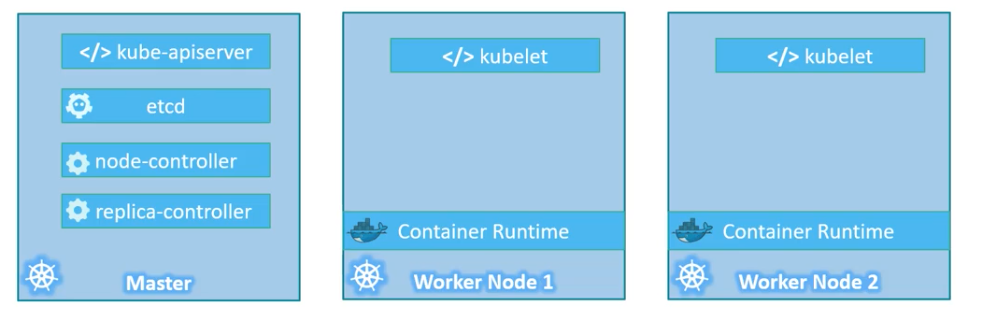

We did step 1(vms) and 2 (docker).

Next step is to install kubeadm, and 
    - kubelet
    - and kubectl

```
sudo apt-get update && sudo apt-get install -y apt-transport-https curl

```

Download key file

```
curl -s https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
```

Add the source list

```
cat <<EOF | sudo tee /etc/apt/sources.list.d/kubernetes.list
deb https://apt.kubernetes.io/ kubernetes-xenial main
EOF
```


Then we issue the update command again:

```
sudo apt-get update
```

Now we ready to install the 3 tools:

1. kubeadm
2. kubectl
3. kubelet


```
apt-get install -y kubelet kubeadm kubectl
```

All the tools are now setup on all the nodes.

Then we move to step 3: That is to initialise a cluster.

Click on link "Using kubeadm to Create a Cluster". Once on this page we see the list of instructions that we need to follow, to configure a kubernetes cluster.

Check the prerequisite: 2GB of RAM, 2 CPUs


We see that we must first install kubeadm, which we have done.

Then we need to initialize the master of control-plane node. The idea here is to run the ```kubeadm init``` command. But before we can do it, we need to look at the notes more clearly...We need to specify additional arguments with the previously mentioned command.


Firstly we need to specify the Pod network addon (we need to scroll downwards)( need to set ```--pod-network-cidr```)


Before we initialize the master we need to make a choice which network we going to use. Rememner we can only install one Pod network per cluster: can use calico,cilium, weavebet, etc; and there are others as well, for the local vm setup.

So we can pass the following argument with the kubeadm init command: ```--pod-network-cidr=10.217.0.0/16```

We can thus issue the following command:

```
kubeadm init --pod-network-cidr=10.217.0.0/16

```

But from the notes you also have to specify the api server: ```--apiserver-advertise-address=<ip-address>``` Remember whe now two ip address: One for the bride adapter (192.168.0...) for teh wifi router and we also created a host only adapter network (192.168.56..) for the static local ip addresses. And the reason why we created the static ip addresses was for the communication between the nodes in cluster. So, here is the essence, when we initialize the master, (and it needs to listen to a particular interface), we must make sure that the master listens to the correct interface or ip address, that is the static ip address. So the master api service will listen to the correct ip address.


And the master node has the static ip address of 192.168.56.2


```
kubeadm init --pod-network-cidr=10.217.0.0/16 --apiserver-advertise-address=192.168.56.2
```

Now we see alot of steps will be performed here...


Having issues with docker: Unstall docker and install it as per kubernetes:

https://kubernetes.io/docs/setup/production-environment/container-runtimes/

(See page 3.  Docker was uninstalled and updated)

Docker reinstalled, lets rerun the above kubeadm (also increased the CPU to 2, and ensured swap is off)

Did not work on first try, so had to clean up as follows:

```
kubeadm reset 
iptables -F && iptables -t nat -F && iptables -t mangle -F && iptables -X

then terminal got stuck

```
Rebooted the host and ssh again, then issued kubeadm init again

then viola...

```
Your Kubernetes control-plane has initialized successfully!

To start using your cluster, you need to run the following as a regular user:

  mkdir -p $HOME/.kube
  sudo cp -i /etc/kubernetes/admin.conf $HOME/.kube/config
  sudo chown $(id -u):$(id -g) $HOME/.kube/config

You should now deploy a pod network to the cluster.
Run "kubectl apply -f [podnetwork].yaml" with one of the options listed at:
  https://kubernetes.io/docs/concepts/cluster-administration/addons/

Then you can join any number of worker nodes by running the following on each as root:

kubeadm join 192.168.56.2:6443 --token 1dqpq7.uqbqv6vdl68oj7q3 \
    --discovery-token-ca-cert-hash sha256:75883721874557649ba963506d65924a342cf885c7aeb73cd8d8b25e95c3b292 

```

So to start the cluster you need to run the following commands as a regular user:

first type ```exit``` to get out of sudo su...

```
mkdir -p $HOME/.kube
sudo cp -i /etc/kubernetes/admin.conf $HOME/.kube/config
sudo chown $(id -u):$(id -g) $HOME/.kube/config
```


[Or if you want to run as root user you can type the following:

```
export KUBECONFIG=/etc/kubernetes/admin.conf
```
]


(make a copy of the join command above)

The next step is to install a POD network. Pod network is required for internal communication, that is between the worker nodes and the master. (This networkin will be covered in more detail in the networking section, so lets just copy and paste what they give us)

(Remember to continue as a regular user)


So now we copy the cilium command on the master as supplied:

```
kubectl create -f https://raw.githubusercontent.com/cilium/cilium/v1.6/install/kubernetes/quick-install.yaml

```

And output generated

```
serviceaccount/cilium created
serviceaccount/cilium-operator created
configmap/cilium-config created
clusterrole.rbac.authorization.k8s.io/cilium created
clusterrole.rbac.authorization.k8s.io/cilium-operator created
clusterrolebinding.rbac.authorization.k8s.io/cilium created
clusterrolebinding.rbac.authorization.k8s.io/cilium-operator created
daemonset.apps/cilium created
deployment.apps/cilium-operator created

```

What the above command did was: setup services to help with interal network communication between the nodes.


Now to check the services that was spun up by kubernetes is, we type

```
kubectl get pods --all-namespaces.

```

And we get the following output.

```
NAMESPACE     NAME                                 READY   STATUS                  RESTARTS   AGE
kube-system   cilium-mtx62                         0/1     Init:ImagePullBackOff   0          2m46s
kube-system   cilium-operator-6dd6ddbd78-k9zns     0/1     Pending                 0          2m46s
kube-system   coredns-66bff467f8-dwhcp             0/1     Pending                 0          20m
kube-system   coredns-66bff467f8-wbq7k             0/1     Pending                 0          20m
kube-system   etcd-kubemaster                      1/1     Running                 0          20m
kube-system   kube-apiserver-kubemaster            1/1     Running                 0          20m
kube-system   kube-controller-manager-kubemaster   1/1     Running                 0          20m
kube-system   kube-proxy-429gt                     1/1     Running                 0          20m
kube-system   kube-scheduler-kubemaster            1/1     Running                 0          20m

```

Got the lastest out, but core dns seem to be up, then crash and errors

```
kube-system   cilium-mtx62                         1/1     Running            1          14m
kube-system   cilium-operator-6dd6ddbd78-k9zns     0/1     Pending            0          14m
kube-system   coredns-66bff467f8-dwhcp             0/1     CrashLoopBackOff   5          31m
kube-system   coredns-66bff467f8-wbq7k             0/1     Error              5          31m
kube-system   etcd-kubemaster                      1/1     Running            0          31m
kube-system   kube-apiserver-kubemaster            1/1     Running            0          31m
kube-system   kube-controller-manager-kubemaster   1/1     Running            0          31m
kube-system   kube-proxy-429gt                     1/1     Running            0          31m
kube-system   kube-scheduler-kubemaster            1/1     Running            0          31m

```

There are pending states, make sure all are running before joining to node

Now we join the master with the node(s). In our case we only have one.

This command must be run on the kubenode-1 node

```
sudo kubeadm join 192.168.56.2:6443 --token 1dqpq7.uqbqv6vdl68oj7q3 --discovery-token-ca-cert-hash sha256:75883721874557649ba963506d65924a342cf885c7aeb73cd8d8b25e95c3b292 
```


Did not connect so stopped the firewall on master and node

```
sudo service ufw stop
```
And we have successful join again

```
This node has joined the cluster:
* Certificate signing request was sent to apiserver and a response was received.
* The Kubelet was informed of the new secure connection details.

Run 'kubectl get nodes' on the control-plane to see this node join the cluster
```


On the master we can now see the nodes.

We get the following output:

```
NAME         STATUS   ROLES    AGE     VERSION
kubemaster   Ready    master   61m     v1.18.2
kubenode-1   Ready    <none>   7m31s   v1.18.2

```
```
NAMESPACE     NAME                                 READY   STATUS             RESTARTS   AGE
kube-system   cilium-fjd6m                         1/1     Running            0          9m28s
kube-system   cilium-mtx62                         1/1     Running            1          44m
kube-system   cilium-operator-6dd6ddbd78-k9zns     1/1     Running            0          44m
kube-system   coredns-66bff467f8-dwhcp             0/1     CrashLoopBackOff   11         62m
kube-system   coredns-66bff467f8-wbq7k             0/1     CrashLoopBackOff   11         62m
kube-system   etcd-kubemaster                      1/1     Running            0          62m
kube-system   kube-apiserver-kubemaster            1/1     Running            0          62m
kube-system   kube-controller-manager-kubemaster   1/1     Running            0          62m
kube-system   kube-proxy-429gt                     1/1     Running            0          62m
kube-system   kube-proxy-vgb7x                     1/1     Running            0          9m28s
kube-system   kube-scheduler-kubemaster            1/1     Running            0          62m
```

Lets deploy an application

We deploy on the master.

```
kubectl run nginx --image=nginx
```
We get the output:

```
NAME    READY   STATUS    RESTARTS   AGE
nginx   1/1     Running   0          3m45s
```
Then we cleanup above example

```
kubectl delete pod nginx --now


```



## Cleanup

____

```
kubectl config delete-cluster
kubectl drain kubemaster --delete-local-data --force --ignore-daemonsets
kubectl drain kubenode-1 --delete-local-data --force --ignore-daemonsets
kubectl delete node <node name>

```
    
    

## When you come back and need to work with nodes

___


Run on all nodes: master and worker
```
sudo kubeadm reset 
sudo iptables -F && iptables -t nat -F && iptables -t mangle -F && iptables -X
sudo service ufw stop
```


Restart the master node and worker node(s)

(on master)
```
sudo kubeadm init --pod-network-cidr=10.217.0.0/16 --apiserver-advertise-address=192.168.56.2

mkdir -p $HOME/.kube
sudo cp -i /etc/kubernetes/admin.conf $HOME/.kube/config
sudo chown $(id -u):$(id -g) $HOME/.kube/config

kubectl create -f https://raw.githubusercontent.com/cilium/cilium/v1.6/install/kubernetes/quick-install.yaml

kubectl get pods --all-namespaces

(on node)
sudo kubeadm join 192.168.56.2:6443 --token 1dqpq7.uqbqv6vdl68oj7q3 --discovery-token-ca-cert-hash sha256:75883721874557649ba963506d65924a342cf885c7aeb73cd8d8b25e95c3b292 

(back not master)
kubectl run nginx --image=nginx
```

## 

## 

## 